# Image Quilting


### Setup phase

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import utils
import os
import random

%matplotlib inline

In [2]:
from utils import cut

### Part I: Randomly Sampled Texture


In [3]:
def quilt_random(sample, out_size, patch_size):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.

    :param sample: numpy.ndarray   The image you read from sample directory
    :param out_size: int            The width of the square output image
    :param patch_size: int          The width of the square sample patch
    :return: numpy.ndarray
    """
    
    # Find the dimensions of the sample image
    sample_rows = len(sample)
    sample_cols = len(sample[0])
    
    # Find a random starting point to create patch
    random_row = int(round(random.random() * (sample_rows - patch_size)))
    random_col = int(round(random.random() * (sample_cols - patch_size)))
    
    # Create patch
    patch = np.zeros((patch_size,patch_size,3), np.uint8)
    for row in range(patch_size):
        for col in range(patch_size):
            patch[row][col] = sample[random_row + row][random_col + col]

    # Number of patches that fit across output image
    patch_copies = int(out_size/patch_size)

    
    # Create output image
    out = np.zeros((out_size,out_size,3), np.uint8)
    for row in range(0, patch_copies*patch_size, patch_size):
            for col in range(0, patch_copies*patch_size, patch_size):
                
                random_row = int(round(random.random() * (sample_rows - patch_size)))
                random_col = int(round(random.random() * (sample_cols - patch_size)))
                
                patch = np.zeros((patch_size,patch_size,3), np.uint8)
                for i in range(patch_size):
                    for j in range(patch_size):
                        patch[i][j] = sample[random_row + i][random_col + j]
                        
                for i in range(patch_size):
                    for j in range(patch_size):
                        out[row+i][col+j] = patch[i][j]

    return out

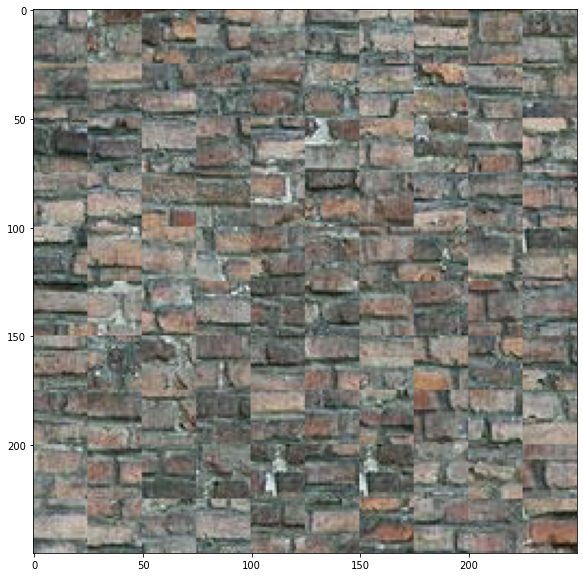

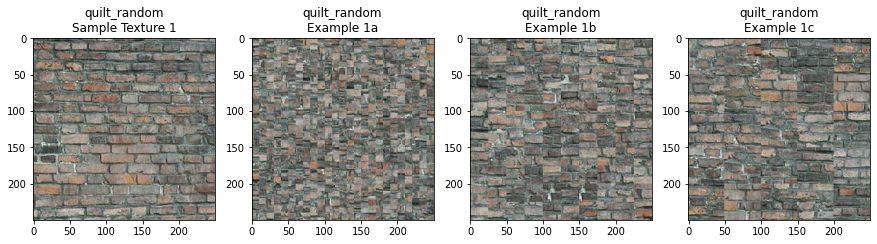

In [4]:
random.seed(10)

quilt_random_sample_1 = cv2.cvtColor(cv2.imread('samples/363.jpg'), cv2.COLOR_BGR2RGB)

quilt_random_example_1a = quilt_random(quilt_random_sample_1, 250, 10)
quilt_random_example_1b = quilt_random(quilt_random_sample_1, 250, 25)
quilt_random_example_1c = quilt_random(quilt_random_sample_1, 250, 50)

plt.figure(figsize = (10,10))
plt.imshow(quilt_random_example_1b)
plt.show()

fig, axes = plt.subplots(1,4, figsize = (15,15))
axes[0].set_title('quilt_random\nSample Texture 1')
axes[0].imshow(quilt_random_sample_1[0:250, 0:250])
axes[1].set_title('quilt_random\nExample 1a')
axes[1].imshow(quilt_random_example_1a)
axes[2].set_title('quilt_random\nExample 1b')
axes[2].imshow(quilt_random_example_1b)
axes[3].set_title('quilt_random\nExample 1c')
axes[3].imshow(quilt_random_example_1c)
plt.show()


### Part II: Overlapping Patches


In [5]:
def ssd_patch(patch, mask, template):
    
    # T, the template is the patch you're trying to fill
    # The template will be of size patch_size x patch_size
    # It will be mostly 0s except for the areas where it overlaps with the previously filled in sections.
    
    # M is the mask: M=0 for non-filled pixels and 1 for filled pixels.
    
    # These should be scale 0-1, not 0-255
    I = patch.copy()/255.0
    M = mask.copy()/255.0
    T = template.copy()/255.0
    
    # "get the cost per channel and then sum across them."
    r_i = I[:, :, 0]
    g_i = I[:, :, 1]
    b_i = I[:, :, 2]

    r_m = M[:, :, 0]
    g_m = M[:, :, 1]
    b_m = M[:, :, 2]
    
    T = T[:, :, 0]

    # Red channel SSD
    I = r_i
    M = r_m
    ssd_r = ((M*T)**2).sum() - 2 * cv2.filter2D(
        I, ddepth=-1, kernel = M*T) + cv2.filter2D(I ** 2, ddepth=-1, kernel=M)

    # Green Channel SSD
    I = g_i
    M = g_m
    ssd_g = ((M*T)**2).sum() - 2 * cv2.filter2D(
        I, ddepth=-1, kernel = M*T) + cv2.filter2D(I ** 2, ddepth=-1, kernel=M)

    # Blue Channel SSD
    I = b_i
    M = b_m    
    ssd_b = ((M*T)**2).sum() - 2 * cv2.filter2D(
        I, ddepth=-1, kernel = M*T) + cv2.filter2D(I ** 2, ddepth=-1, kernel=M)
    
    # Sum of SSDs
    ssd = ssd_r + ssd_g + ssd_b

    return ssd


In [6]:
def choose_sample(cost_image, sample, patch_size, tol):
    # Suggested methodologies
    #   row, col = np.where(cost < minc*(1+tol))
    #   minc=max(minc,small_cost_value)
    
    sorted_costs = sorted(cost_image.flatten())
    
    keep_looking = True
    goto_row = 0
    goto_col = 0
    
    for cost in sorted_costs:    
        if keep_looking and cost > tol:
            
            # Find the location
            row, col = np.where(cost_image == cost)

            if (row[0] + patch_size) < (len(sample) - 1) and (col[0] + patch_size) < (len(sample[0]) - 1):
                if int(round(random.random())) == 0:
                    keep_looking = False
                    goto_row = row[0]
                    goto_col = col[0]
                    
    patch = np.zeros((patch_size,patch_size,3), np.uint8)
    for row in range(patch_size):
        for col in range(patch_size):
            patch[row][col] = sample[int(goto_row) + row][int(goto_col) + col]
    
    return patch


In [7]:
def quilt_simple(sample, out_size, patch_size, overlap, tol):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :return: numpy.ndarray
    """
    
    if patch_size % 2 == 0:
        # "Use an odd value for patch_size so that its center is well-defined."
        return None
    
    patch_copies = int(out_size/(patch_size-overlap))
    
    # Create the output image
    out = np.zeros((out_size,out_size,3), np.uint8)
    
    for row in range(0, patch_copies*(patch_size-overlap), patch_size-overlap):
        for col in range(0, patch_copies*(patch_size-overlap), patch_size-overlap):
            
            mask = np.zeros((patch_size,patch_size,3), np.uint8)
            template = np.zeros((patch_size,patch_size,3), np.uint8)
            
            if row == 0 and col == 0:
                # Fill the top left corner of the image
                
                # Find the dimensions of the sample image
                sample_rows = len(sample)
                sample_cols = len(sample[0])
    
                # Find a random starting point to create patch
                random_row = int(round(random.random() * (sample_rows - patch_size)))
                random_col = int(round(random.random() * (sample_cols - patch_size)))
                
                #print(random_row)
                #print(random_col)

                # Create patch
                patch = np.zeros((patch_size,patch_size,3), np.uint8)
                for i in range(patch_size):
                    for j in range(patch_size):
                        patch[i][j] = sample[random_row+i][random_col+j]

                # Add the patch to the image
                for i in range(patch_size):
                    for j in range(patch_size):
                        out[i][j] = patch[i][j]

            elif row == 0:      
                # Fill the top edge of the image
                
                # Create a new mask and template
                for i in range(patch_size):
                    for j in range(overlap):
                        mask[i][j] = 255
                        if row+i < out_size and col+j < out_size:
                            template[i][j] = out[i+row][j+col]
   
                patch = choose_sample(ssd_patch(out, mask, template), sample, patch_size, tol)

                # Add the patch to the image
                for i in range(patch_size):
                    for j in range(patch_size):
                        if row+i < out_size and col+j < out_size:
                            out[row+i][col+j] = patch[i][j]

            elif col == 0:
                # Fill the left edge of the image
                
                # Create a new mask and template
                for i in range(overlap):
                    for j in range(patch_size):
                        mask[i][j] = 255
                        if row+i < out_size and col+j < out_size:
                            template[i][j] = out[i+row][j+col]
                        
                patch = choose_sample(ssd_patch(out, mask, template), sample, patch_size, tol)

                # Add the patch to the image
                for i in range(patch_size):
                    for j in range(patch_size):
                        if row+i < out_size and col+j < out_size:
                            out[row+i][col+j] = patch[i][j]

            else:
                # Fill the rest of the image
                
                # Create a new mask and template
                for i in range(overlap):
                    for j in range(patch_size):
                        mask[i][j] = 255
                        if row+i < out_size and col+j < out_size:
                            template[i][j] = out[i+row][j+col]
                for i in range(patch_size):
                    for j in range(overlap):
                        mask[i][j] = 255
                        if row+i < out_size and col+j < out_size:
                            template[i][j] = out[row+i][col+j]
                
                patch = choose_sample(ssd_patch(out, mask, template), sample, patch_size, tol)

                # Add the patch to the image
                for i in range(patch_size):
                    for j in range(patch_size):
                        if row+i < out_size and col+j < out_size:
                            out[row+i][col+j] = patch[i][j]


    return out

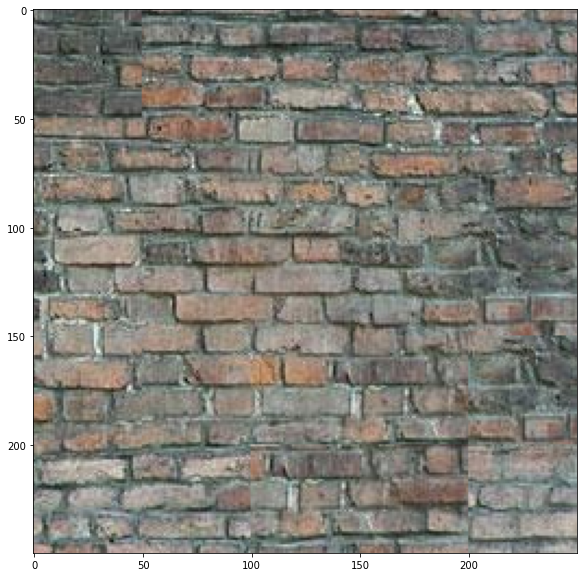

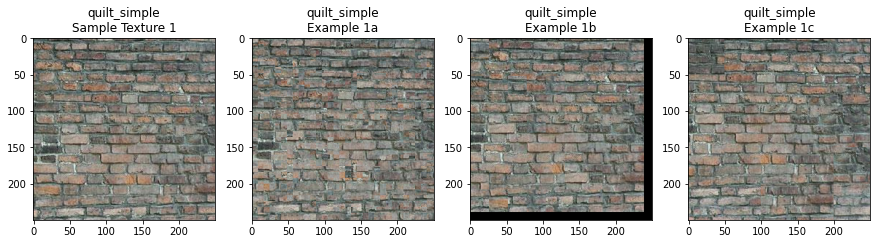

In [8]:
random.seed(10)
quilt_simple_sample_1 = cv2.cvtColor(cv2.imread('samples/363.jpg'), cv2.COLOR_BGR2RGB)

quilt_simple_example_1a = quilt_simple(quilt_simple_sample_1, 250, 11, 3, 0.005)
quilt_simple_example_1b = quilt_simple(quilt_simple_sample_1, 250, 31, 5, 1.95)
quilt_simple_example_1c = quilt_simple(quilt_simple_sample_1, 250, 57, 7, 0.5)

plt.figure(figsize = (10,10))
plt.imshow(quilt_simple_example_1c)
plt.show()

fig, axes = plt.subplots(1,4, figsize = (15,15))
axes[0].set_title('quilt_simple\nSample Texture 1')
axes[0].imshow(quilt_simple_sample_1[0:250, 0:250])
axes[1].set_title('quilt_simple\nExample 1a')
axes[1].imshow(quilt_simple_example_1a)
axes[2].set_title('quilt_simple\nExample 1b')
axes[2].imshow(quilt_simple_example_1b)
axes[3].set_title('quilt_simple\nExample 1c')
axes[3].imshow(quilt_simple_example_1c)
plt.show()

#### Comparing `quilt_random` and `quilt_simple` Results:

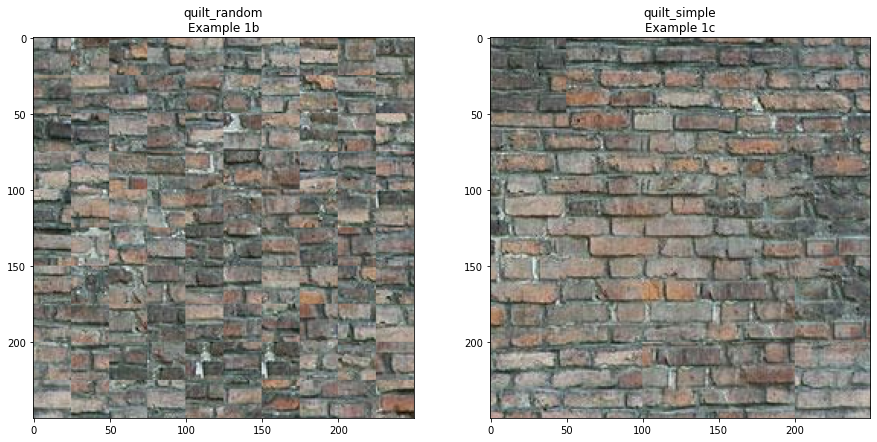

In [9]:
fig, axes = plt.subplots(1,2, figsize = (15,15))
axes[0].set_title('quilt_random\nExample 1b')
axes[0].imshow(quilt_random_example_1b)
axes[1].set_title('quilt_simple\nExample 1c')
axes[1].imshow(quilt_simple_example_1c)
plt.show()

### Part III: Seam Finding


In [10]:
def quilt_cut(sample, out_size, patch_size, overlap, tol):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :return: numpy.ndarray
    """
    
    output_cut_demo = True
    if patch_size % 2 == 0:
        # "Use an odd value for patch_size so that its center is well-defined."
        return None
    
    patch_copies = int(out_size/(patch_size-overlap))
    
    # Create the output image
    out = np.zeros((out_size,out_size,3), np.uint8)
    
    for row in range(0, patch_copies*(patch_size-overlap), patch_size-overlap):
        for col in range(0, patch_copies*(patch_size-overlap), patch_size-overlap):
            
            mask = np.zeros((patch_size,patch_size,3), np.uint8)
            template = np.zeros((patch_size,patch_size,3), np.uint8)
            
            if row == 0 and col == 0:
                # Fill the top left corner of the image
                
                # Find the dimensions of the sample image
                sample_rows = len(sample)
                sample_cols = len(sample[0])
    
                # Find a random starting point to create patch
                random_row = int(round(random.random() * (sample_rows - patch_size)))
                random_col = int(round(random.random() * (sample_cols - patch_size)))
                
                # Create patch
                patch = np.zeros((patch_size,patch_size,3), np.uint8)
                for i in range(patch_size):
                    for j in range(patch_size):
                        patch[i][j] = sample[random_row+i][random_col+j]

                # Add the patch to the image
                for i in range(patch_size):
                    for j in range(patch_size):
                        out[i][j] = patch[i][j]

            elif row == 0:      
                # Fill the top edge of the image
                
                # Create a new mask and template
                for i in range(patch_size):
                    for j in range(overlap):
                        mask[i][j] = 255
                        if row+i < out_size and col+j < out_size:
                            template[i][j] = out[i+row][j+col]

   
                patch = choose_sample(ssd_patch(out, mask, template), sample, patch_size, tol)
    
                # For cutting, take template = target portion
                # take section of patch that overlaps, then compare them
            
                patch_template = patch.copy()
                for i in range(patch_size):
                    for j in range(patch_size):
                        if mask[i][j].sum() == 0:
                            patch_template[i][j] = 0
                            
                #cut_cost = ssd_patch(template, mask, patch_template)
                #cut_mask = cut(cut_cost)

                vertical_mask = mask[0:patch_size,0:overlap]
                vertical_mask=cv2.transpose(vertical_mask)
                vertical_mask=cv2.flip(vertical_mask,flipCode=1)
                vertical_template = template[0:patch_size,0:overlap]
                vertical_template=cv2.transpose(vertical_template)
                vertical_template=cv2.flip(vertical_template,flipCode=1)
                vertical_patch_template = patch[0:patch_size,0:overlap]
                vertical_patch_template=cv2.transpose(vertical_patch_template)
                vertical_patch_template=cv2.flip(vertical_patch_template,flipCode=1)
                vertical_cut_cost = ssd_patch(vertical_template, vertical_mask, vertical_patch_template)
                vertical_cut_mask = np.rot90(cut(vertical_cut_cost), 1)

                new_patch = patch.copy()
                for i in range(patch_size):
                    for j in range(overlap):
                        if vertical_cut_mask[i][j] == 1:
                            new_patch[i][j] = 0


                # Add the patch to the image
                for i in range(patch_size):
                    for j in range(patch_size):
                        if row+i < out_size and col+j < out_size:
                            if not new_patch[i][j].sum() == 0:
                                out[row+i][col+j] = new_patch[i][j]

            elif col == 0:
                # Fill the left edge of the image
                
                # Create a new mask and template
                for i in range(overlap):
                    for j in range(patch_size):
                        mask[i][j] = 255
                        if row+i < out_size and col+j < out_size:
                            template[i][j] = out[i+row][j+col]
                        
                patch = choose_sample(ssd_patch(out, mask, template), sample, patch_size, tol)
                
                patch_template = patch.copy()
                for i in range(patch_size):
                    for j in range(patch_size):
                        if mask[i][j].sum() == 0:
                            patch_template[i][j] = 0
                            
                #cut_cost = ssd_patch(template, mask, patch_template)
                #cut_mask = cut(cut_cost)

                horizontal_mask = mask[0:overlap,0:patch_size]
                horizontal_template = template[0:overlap,0:patch_size]
                horizontal_patch_template = patch_template[0:overlap,0:patch_size]
                horizontal_cut_cost = ssd_patch(horizontal_template, horizontal_mask, horizontal_patch_template)
                horizontal_cut_mask = cut(horizontal_cut_cost)

                new_patch = patch.copy()
                for i in range(overlap):
                    for j in range(patch_size):
                        if horizontal_cut_mask[i][j] == 1:
                            new_patch[i][j] = 0

                # Add the patch to the image
                for i in range(patch_size):
                    for j in range(patch_size):
                        if row+i < out_size and col+j < out_size:
                            if not new_patch[i][j].sum() == 0:
                                out[row+i][col+j] = new_patch[i][j]


            else:
                # Fill the rest of the image
                
                # Create a new mask and template
                for i in range(overlap):
                    for j in range(patch_size):
                        mask[i][j] = 255
                        if row+i < out_size and col+j < out_size:
                            template[i][j] = out[i+row][j+col]
                for i in range(patch_size):
                    for j in range(overlap):
                        mask[i][j] = 255
                        if row+i < out_size and col+j < out_size:
                            template[i][j] = out[row+i][col+j]
                
                patch = choose_sample(ssd_patch(out, mask, template), sample, patch_size, tol)
                
                patch_template = patch.copy()
                for i in range(patch_size):
                    for j in range(patch_size):
                        if mask[i][j].sum() == 0:
                            patch_template[i][j] = 0

                horizontal_mask = mask[0:overlap,0:patch_size]
                horizontal_template = template[0:overlap,0:patch_size]
                horizontal_patch_template = patch_template[0:overlap,0:patch_size]
                horizontal_cut_cost = ssd_patch(horizontal_template, horizontal_mask, horizontal_patch_template)
                horizontal_cut_mask = cut(horizontal_cut_cost)

                vertical_mask = mask[0:patch_size,0:overlap]
                vertical_mask=cv2.transpose(vertical_mask)
                vertical_mask=cv2.flip(vertical_mask,flipCode=1)
                vertical_template = template[0:patch_size,0:overlap]
                vertical_template=cv2.transpose(vertical_template)
                vertical_template=cv2.flip(vertical_template,flipCode=1)
                vertical_patch_template = patch[0:patch_size,0:overlap]
                vertical_patch_template=cv2.transpose(vertical_patch_template)
                vertical_patch_template=cv2.flip(vertical_patch_template,flipCode=1)
                vertical_cut_cost = ssd_patch(vertical_template, vertical_mask, vertical_patch_template)
                vertical_cut_mask = np.rot90(cut(vertical_cut_cost), 1)
                
                
                new_patch = patch.copy()
                for i in range(overlap):
                    for j in range(patch_size):
                        if horizontal_cut_mask[i][j] == 0:
                            new_patch[i][j] = 0
                for i in range(patch_size):
                    for j in range(overlap):
                        if vertical_cut_mask[i][j] == 0:
                            new_patch[i][j] = 0
                            
                if output_cut_demo:
                    output_cut_demo = False
                    new_patch_demo = new_patch.copy()
                    
                    #add_red = True
                    for i in range(overlap):
                        for j in range(patch_size):

                            #add_red = True
                            
                            if not new_patch[i+1][j].sum() == 0 and new_patch[i][j].sum() == 0:
                                new_patch_demo[i][j][0] = 255

                    for i in range(patch_size):
                        add_red = True
                        for j in range(overlap):
                            if not new_patch[i][j+1].sum() == 0 and add_red:
                                new_patch_demo[i][j][0] = 255
                                add_red = False

                    fig, axes = plt.subplots(1,3, figsize = (15,15))
                    axes[0].set_title('Target Template')
                    axes[0].imshow(template)
                    axes[1].set_title('Patch')
                    axes[1].imshow(patch)
                    axes[2].set_title('"Cut" Patch')
                    axes[2].imshow(new_patch_demo)
                    plt.show()


                # Add the patch to the image
                for i in range(patch_size):
                    for j in range(patch_size):
                        if row+i < out_size and col+j < out_size:
                            if not new_patch[i][j].sum() == 0:
                                out[row+i][col+j] = new_patch[i][j]


    return out


#### Example #1

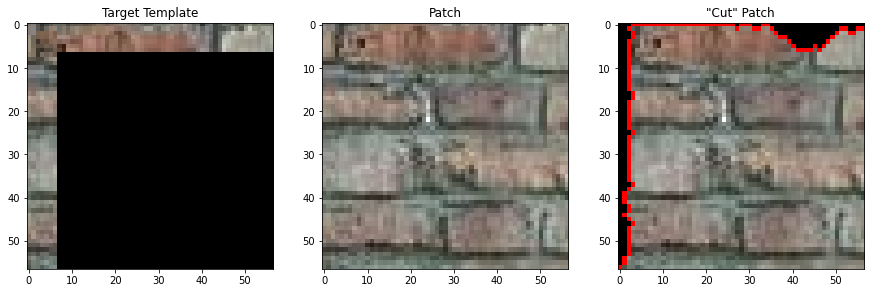

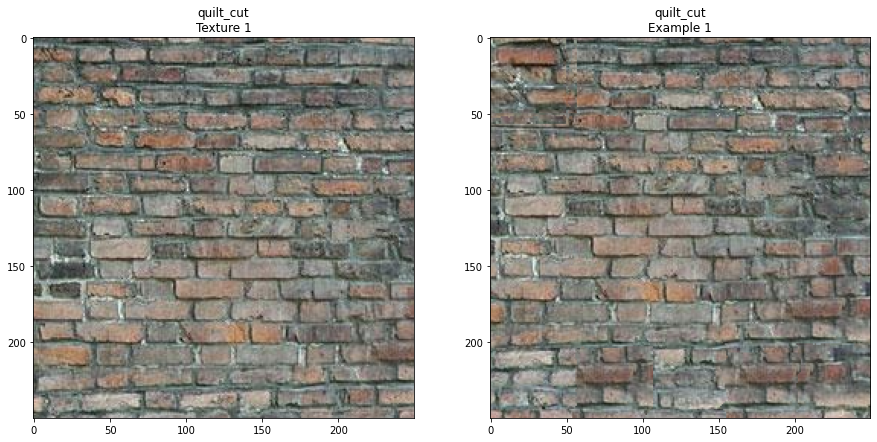

In [11]:
random.seed(20)

quilt_cut_sample_1 = cv2.cvtColor(cv2.imread('samples/363.jpg'), cv2.COLOR_BGR2RGB)
quilt_cut_example_1 = quilt_cut(quilt_cut_sample_1, 250, 57, 7, 0.5)

fig, axes = plt.subplots(1,2, figsize = (15,15))
axes[0].set_title('quilt_cut\nTexture 1')
axes[0].imshow(quilt_cut_sample_1[0:250, 0:250])
axes[1].set_title('quilt_cut\nExample 1')
axes[1].imshow(quilt_cut_example_1)
plt.show()


#### Example #2

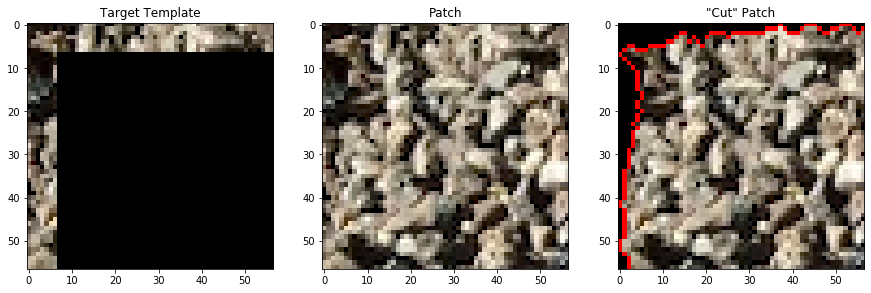

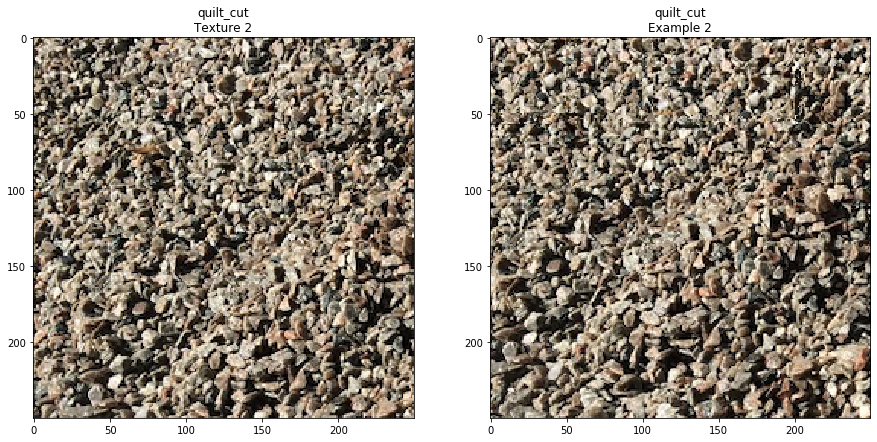

In [349]:
random.seed(32)

quilt_cut_sample_2 = cv2.cvtColor(cv2.imread('samples/gravel_b.jpg'), cv2.COLOR_BGR2RGB)
quilt_cut_example_2 = quilt_cut(quilt_cut_sample_2, 250, 57, 7, 0.5)

fig, axes = plt.subplots(1,2, figsize = (15,15))
axes[0].set_title('quilt_cut\nTexture 2')
axes[0].imshow(quilt_cut_sample_2[0:250, 0:250])
axes[1].set_title('quilt_cut\nExample 2')
axes[1].imshow(quilt_cut_example_2)
plt.show()


#### Example #3

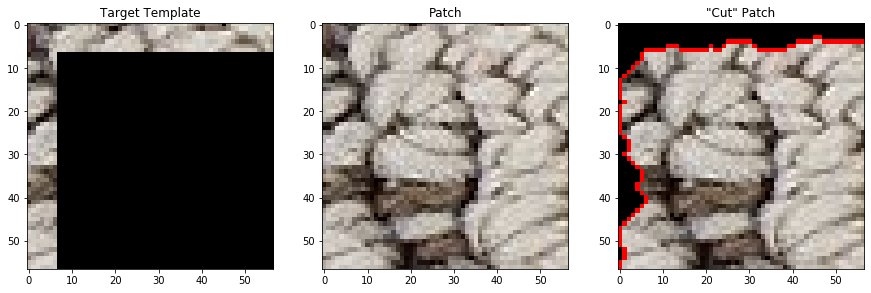

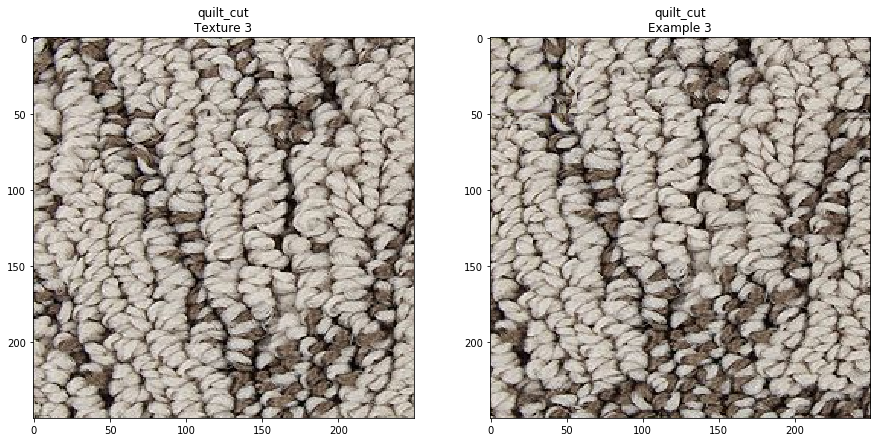

In [319]:
random.seed(20)

quilt_cut_sample_3 = cv2.cvtColor(cv2.imread('samples/carpet.jpg'), cv2.COLOR_BGR2RGB)
quilt_cut_example_3 = quilt_cut(quilt_cut_sample_3, 250, 57, 7, 0.5)

fig, axes = plt.subplots(1,2, figsize = (15,15))
axes[0].set_title('quilt_cut\nTexture 3')
axes[0].imshow(quilt_cut_sample_3[0:250, 0:250])
axes[1].set_title('quilt_cut\nExample 3')
axes[1].imshow(quilt_cut_example_3)
plt.show()


#### Example #4

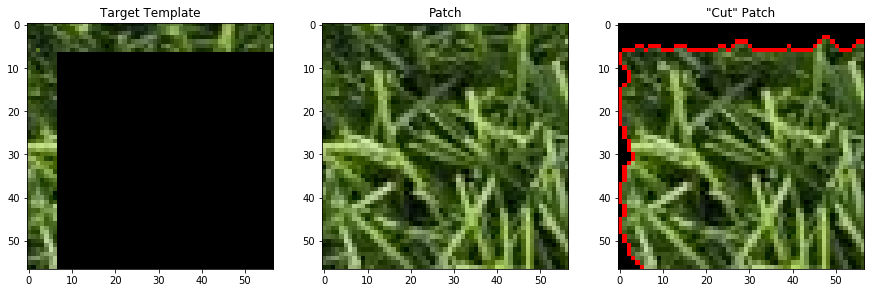

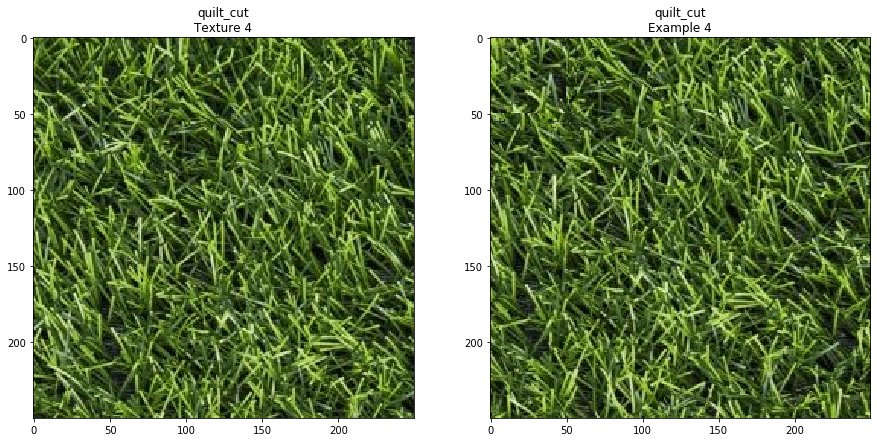

In [320]:
random.seed(20)

quilt_cut_sample_4 = cv2.cvtColor(cv2.imread('samples/grass.jpg'), cv2.COLOR_BGR2RGB)
quilt_cut_example_4 = quilt_cut(quilt_cut_sample_4, 250, 57, 7, 0.5)

fig, axes = plt.subplots(1,2, figsize = (15,15))
axes[0].set_title('quilt_cut\nTexture 4')
axes[0].imshow(quilt_cut_sample_4[0:250, 0:250])
axes[1].set_title('quilt_cut\nExample 4')
axes[1].imshow(quilt_cut_example_4)
plt.show()


#### Example #5

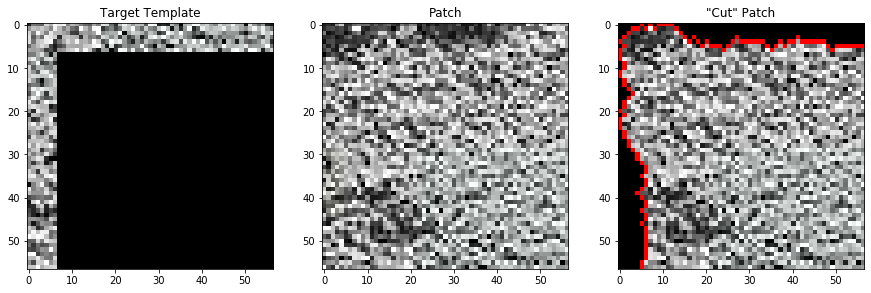

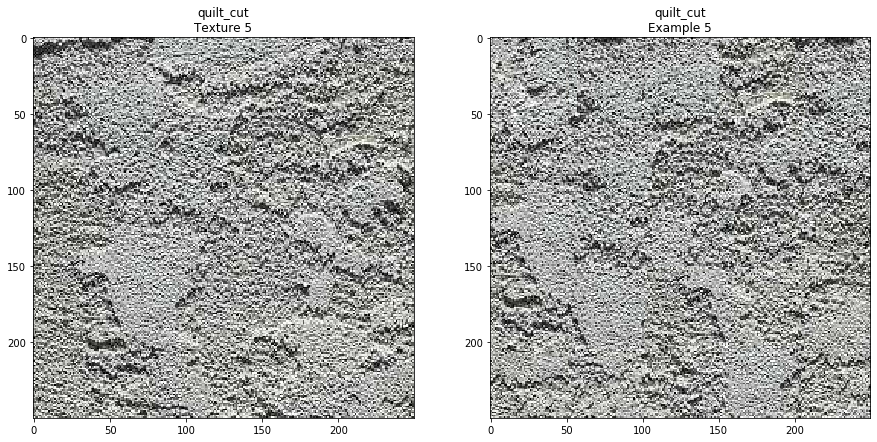

In [305]:
random.seed(20)

quilt_cut_sample_5 = cv2.cvtColor(cv2.imread('samples/stucco.jpg'), cv2.COLOR_BGR2RGB)
quilt_cut_example_5 = quilt_cut(quilt_cut_sample_5, 250, 57, 7, 0.5)

fig, axes = plt.subplots(1,2, figsize = (15,15))
axes[0].set_title('quilt_cut\nTexture 5')
axes[0].imshow(quilt_cut_sample_5[0:250, 0:250])
axes[1].set_title('quilt_cut\nExample 5')
axes[1].imshow(quilt_cut_example_5)
plt.show()


### Comparing `quilt_simple` and `quilt_cut` Results:

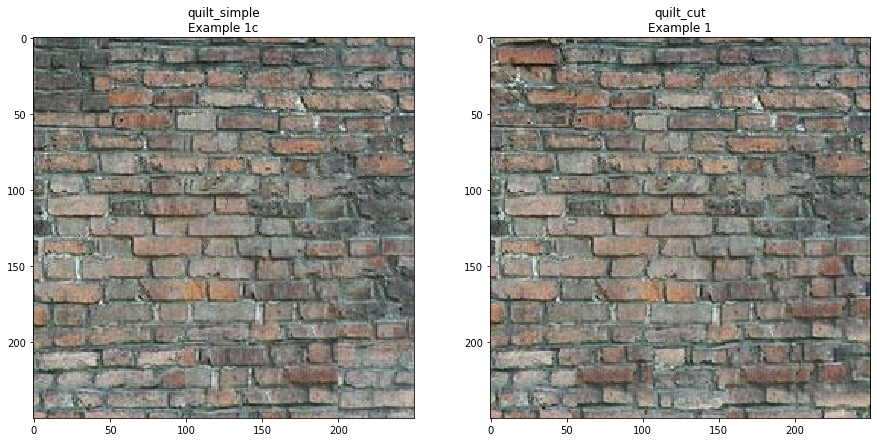

In [321]:
fig, axes = plt.subplots(1,2, figsize = (15,15))
axes[0].set_title('quilt_simple\nExample 1c')
axes[0].imshow(quilt_simple_example_1c)
axes[1].set_title('quilt_cut\nExample 1')
axes[1].imshow(quilt_cut_example_1)
plt.show()

### Part IV: Texture Transfer


In [322]:
def grayscale_blur(rgb_image):
    
    # Step 1. Ensure high contrast images for better results
    
    # Convert RGB to LAB
    lab = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2LAB)

    # Split the channels out of the LAB image
    lightness, color_channel_a, color_channel_b = cv2.split(lab)

    # Create a Contrast Limited AHE with default values
    clahe = cv2.createCLAHE()

    # Apply it only only to the "Lightness" channel
    enlightenment = clahe.apply(lightness)

    # Create a new LAB image with enhanced L and original A & B channels
    enlightened_lab = cv2.merge((enlightenment, color_channel_a, color_channel_b))

    # Convert the LAB image to the RGB color space
    enlightened_rgb = cv2.cvtColor(enlightened_lab, cv2.COLOR_LAB2RGB)

    
    # Step 2. Convert to usable grayscale image
    
    gray = cv2.cvtColor(enlightened_rgb, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (59, 59), 5, cv2.BORDER_REFLECT)
    result = blur / 255.0
    
    return result

In [323]:
def ssd_grayscale(patch, mask, template):
    
    # T, the template is the patch you're trying to fill
    # The template will be of size patch_size x patch_size
    # It will be mostly 0s except for the areas where it overlaps with the previously filled in sections.
    # "the actual chunk", but in grayscale
    
    # M is the mask: M=0 for non-filled pixels and 1 for filled pixels.
    # should a chunk of the target

    I = patch
    M = mask
    T = template
    
    ssd = ((M*T)**2).sum() - 2 * cv2.filter2D(I, ddepth=-1, kernel = M*T) + cv2.filter2D(I ** 2, ddepth=-1, kernel=M)

    return ssd


In [324]:
def choose_texture(cost_image, sample, patch_size):

    sorted_costs = sorted(cost_image.flatten())[0:1000]
    
    goto_row = 0
    goto_col = 0
    counter = 0
    
    while True:

        row, col = np.where(cost_image == sorted_costs[counter])
        
        if (row[0] + patch_size) < (len(sample) - 1) and (col[0] + patch_size) < (len(sample[0]) - 1):
            goto_row = row[0]
            goto_col = col[0]
            break
            
        counter += 1
                    
    patch = np.zeros((patch_size,patch_size,3), np.uint8)
    for row in range(patch_size):
        for col in range(patch_size):
            patch[row][col] = sample[int(goto_row) + row][int(goto_col) + col]
    
    return patch


In [325]:
def texture_transfer(sample, target, patch_size):
    """
    Feel free to add function parameters
    """

    gray_sample = grayscale_blur(sample)
    gray_target = grayscale_blur(target)

    out_size = len(target)
    patch_copies = int(out_size/patch_size)
    out = target.copy()
    
    for row in range(0, patch_copies*patch_size, patch_size):
        for col in range(0, patch_copies*patch_size, patch_size):
            
            mask = gray_sample.copy()[row:row+patch_size,col:col+patch_size]     
            template = gray_target.copy()[row:row+patch_size,col:col+patch_size]
            patch = choose_texture(ssd_grayscale(gray_sample, mask, template), sample, patch_size)
            
            for i in range(patch_size):
                for j in range(patch_size):
                    if row+i < out_size and col+j < out_size:
                        out[row+i][col+j] = patch[i][j]

    return out


#### Example #1

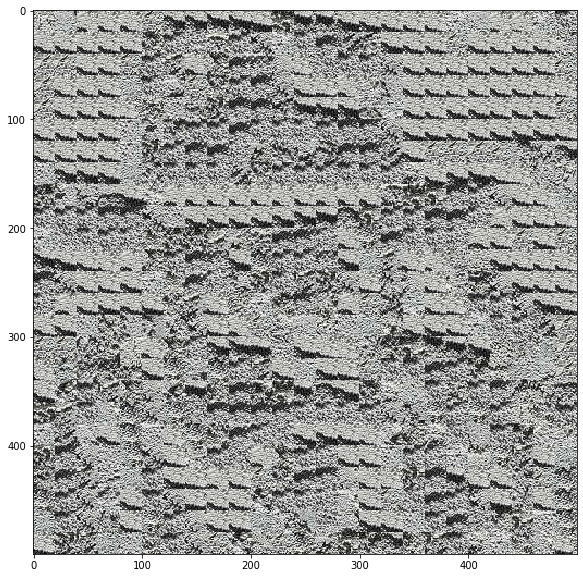

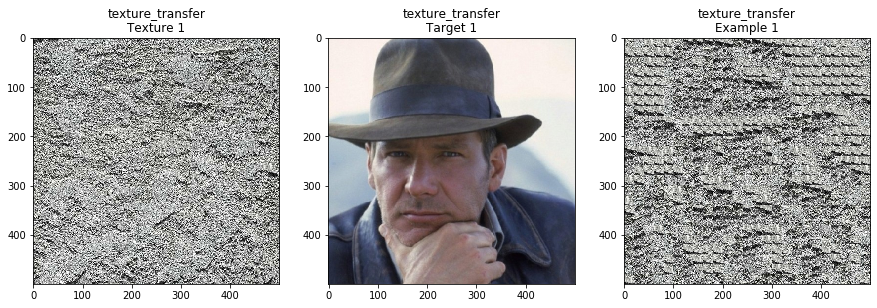

In [326]:
random.seed(10)

texture_xfer_sample_1 = cv2.cvtColor(cv2.imread('samples/stucco.jpg'), cv2.COLOR_BGR2RGB)
texture_xfer_target_1 = cv2.cvtColor(cv2.imread('samples/harrison.jpg'), cv2.COLOR_BGR2RGB)
texture_xfer_example_1 = texture_transfer(texture_xfer_sample_1, texture_xfer_target_1, 20)

plt.figure(figsize = (10,10))
plt.imshow(texture_xfer_example_1)
plt.show()

fig, axes = plt.subplots(1,3, figsize = (15,15))
axes[0].set_title('texture_transfer\nTexture 1')
axes[0].imshow(texture_xfer_sample_1)
axes[1].set_title('texture_transfer\nTarget 1')
axes[1].imshow(texture_xfer_target_1)
axes[2].set_title('texture_transfer\nExample 1')
axes[2].imshow(texture_xfer_example_1)
plt.show()


#### Example #2

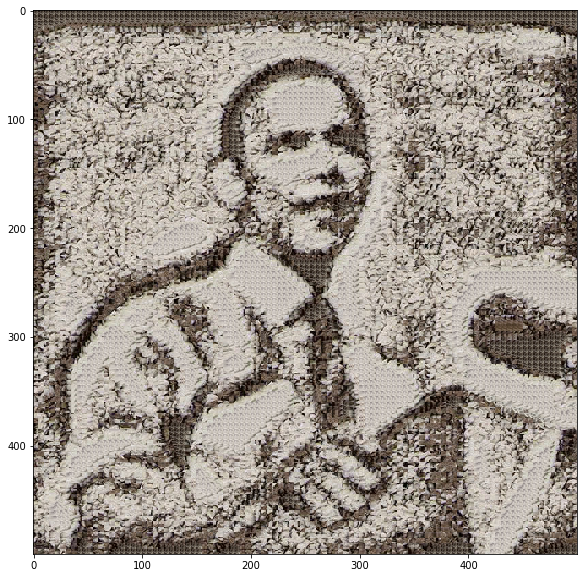

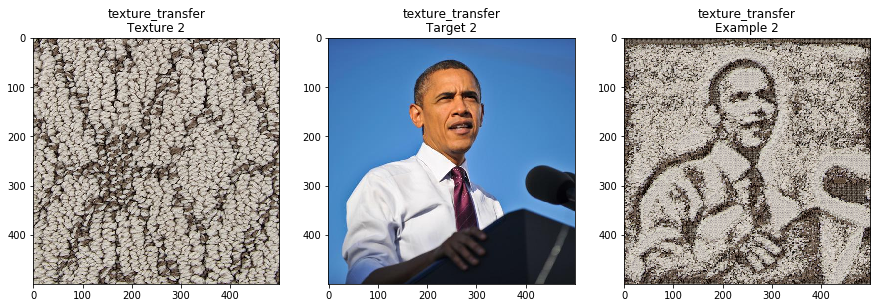

In [350]:
random.seed(10)

texture_xfer_sample_2 = cv2.cvtColor(cv2.imread('samples/carpet.jpg'), cv2.COLOR_BGR2RGB)
texture_xfer_target_2 = cv2.cvtColor(cv2.imread('samples/obama.jpg'), cv2.COLOR_BGR2RGB)
texture_xfer_example_2 = texture_transfer(texture_xfer_sample_2, texture_xfer_target_2, 5)

plt.figure(figsize = (10,10))
plt.imshow(texture_xfer_example_2)
plt.show()

fig, axes = plt.subplots(1,3, figsize = (15,15))
axes[0].set_title('texture_transfer\nTexture 2')
axes[0].imshow(texture_xfer_sample_2)
axes[1].set_title('texture_transfer\nTarget 2')
axes[1].imshow(texture_xfer_target_2)
axes[2].set_title('texture_transfer\nExample 2')
axes[2].imshow(texture_xfer_example_2)
plt.show()
